## Assignment 2: Adversarial attacks and defenses
**Course:** Security and Interpretability of Machine Learning algorithms <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 

### Abstract

This notebook contains implementations for a known adversarial attacks, e.g. FGSM, PGD, and C&W. Their impact on a ResNet-34 is measured using balanced accuracy with correspondent values of x, x, and x. The robustness against adversarial examples was increased with balanced accurace x before and x after, but with the decay of accuracy on test set of x before and x after. 

### 0. Prerequisites.

In [1]:
import torch 
import torchvision
import os
import pickle
import matplotlib
import albumentations as A
import random
import numpy as np
import random

In [2]:
from albumentations import pytorch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score
from abc import ABC, abstractmethod
from sklearn.metrics import ConfusionMatrixDisplay
from time import time

In [3]:
configs = {
    "num_workers": 4,
    "device": "cuda:0",
    "batch_size": 128,
    "epochs": 50
}

In [4]:
import warnings
warnings.filterwarnings("ignore")

### 1. Loading data 

The CIFAR-10 dataset was downloaded from [official publisher](https://www.cs.toronto.edu/~kriz/cifar.html) and mounted to `data/cifar/` directory. Further, the loading of data will be performed through Dataset abstraction. Native implementation does not support transforms via Albumentations package, so I create a custom class for this purpose.

In [5]:
class AlbumentationsCIFAR10(CIFAR10):
    """
    Custom CIFAR10 dataset applying transformations according to
    Albumentations standard. Inherited from native PyTorch dataset
    implementing the retrival logic.
    """
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]
        if self.transform is None:
            return image, label
        try:
            transformed = self.transform(image=image)['image']
        except Exception as e:
            print(e)
            transformed = self.transform(image)
        return transformed, label
            

There will be two types of transforms: train and test. Both include the normalization and converting to Tensors. Still, the former one also applies random augmentations to increase the robustness of the model. For instance, there are horizontal flip, scale rotations, elastic transforms. By construction, augmentations will be applied on each epoch, so that the model will be trained on previously unseen samples.

In [6]:
train_augmentations = A.Compose([
    # A.augmentations.transforms.Normalize(),
    A.HorizontalFlip(p=0.5),
    A.augmentations.geometric.transforms.ShiftScaleRotate(p=0.5),
    A.augmentations.geometric.transforms.ElasticTransform(p=0.1),
    pytorch.transforms.ToTensorV2(),
])

test_augmentations = A.Compose([
    # A.augmentations.transforms.Normalize(),
    pytorch.transforms.ToTensorV2(),
])

Further in the notebook, there will be used validation, train, and test datasets. The validation set will be used to check the overall performance of the trained model. The train and test sets will be used for training the model.

In [7]:
trainset = AlbumentationsCIFAR10(root='data', train=True, download=True, transform=train_augmentations)
trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, num_workers=configs['num_workers'])

Files already downloaded and verified


In [8]:
split_ration = 0.5

controlset = AlbumentationsCIFAR10(root='data', train=False, download=True, transform=test_augmentations)
test_size = int(split_ration * len(controlset))
validation_size = len(controlset) - test_size
testset, validationset = torch.utils.data.random_split(controlset, [test_size, validation_size], generator=torch.Generator().manual_seed(42))
testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])
validationloader = DataLoader(validationset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])

Files already downloaded and verified


In [9]:
print(f"Datasets' sizes: train {len(trainset)}, test: {len(testset)}, validation: {len(validationset)}")

Datasets' sizes: train 50000, test: 5000, validation: 5000


Let's examine five random samples from training population. The images themselves are a litle bit messy, but still the depicted entity can be distinguished. Note that these are the images after transformations (different from the original).

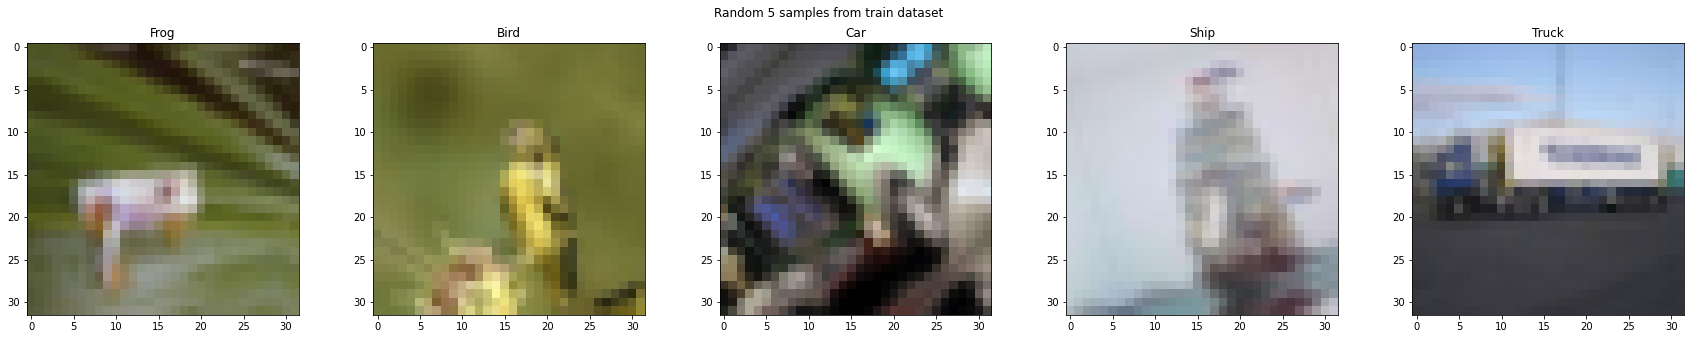

In [10]:
labels_text = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes = {i: labels_text[i] for i in range(len(labels_text))}

fig, axes = plt.subplots(1, 5)
fig.set_size_inches(30, 5)
fig.suptitle("Random 5 samples from train dataset")
for ax in axes:
    idx = random.randint(0, len(trainset)-1)
    image, label = trainset[idx]
    image = image / 255.0
    ax.set_title(f"{classes[label]}")
    image = np.clip(image.permute(1, 2, 0), 0, 1)
    ax.imshow(image)
plt.show()

### 2. Inference model

Multi-label classification of objects in images is known problem. Various state-of-art model were developed. For instance, the Residual Network (ResNet) significantly improved the performance of deep neural networks. The overall idea and architecture are presented in ["Deep Residual Learning for Image Recognition"](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming H. et al. For this assignment I will implement the variation of ResNet with 34 layers.

In [11]:
class ResidualBlock(nn.Module):
    """
    Building block for residual network. Implements an idea of skip connections 
    (a.k.a. shortcuts). Default configuration involves triple-layre skip. 
    """
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = self.__make_shortcut()
        
    def __make_shortcut(self):
        if self.stride == 1 and self.expansion * self.out_channels == self.in_channels:
            return nn.Sequential()
        shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expansion * self.out_channels, kernel_size=1, stride=self.stride, bias=False),
            nn.BatchNorm2d(self.expansion * self.out_channels) 
        )
        return shortcut
    
    def forward(self, x):
        _x = x.clone() 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.shortcut(_x)
        x = F.relu(x)
        return x

In [12]:
class ResNet(nn.Module):
    """
    Class implementing the Residual Network by Kaiming H. et al.
    Comprised of blocks with skip connections to preserve sensitive information 
    over the layers. By default, performs multi-label classification for 10 classes.
    """
    
    def __init__(self, in_channels, out_channels, blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.blocks = blocks
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.layers = []
        channels = out_channels
        for idx, num_blocks in enumerate(blocks):
            stride = 1 if idx == 0 else 2
            layer = self.__make_layer(ResidualBlock, channels, num_blocks, stride)
            self.layers.append(layer)
            channels *= 2  
        self.layers = nn.ModuleList(self.layers)
        
        self.fc1 = nn.Linear(channels // 2 * ResidualBlock.expansion, num_classes) 

    def __make_layer(self, Block, channels, num_blocks, first_stride):
        blocks = []
        for idx in range(num_blocks):
            stride = first_stride if idx == 0 else 1
            block = Block(self.out_channels, channels, stride)
            self.out_channels = channels * Block.expansion
            blocks.append(block)
        layer = nn.Sequential(*blocks)
        return layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        for layer in self.layers:
            x = layer(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

The best performance is shown on the epoch 50 (see Assignment 1), so these weights will be used for inference. Since the weights weigh a lot (~260 Mb), I uploaded them on [google drive](https://drive.google.com/file/d/1FlUsruxRa86CEcermysA9GT5mEwlKdcb/view?usp=sharing).

In [13]:
checkpoint = torch.load(os.path.join("weights", "baseline.pt"))
baseline = ResNet(3, 64, [3, 4, 6, 3]).to(configs['device'])
baseline.load_state_dict(checkpoint['model_state_dict'])
baseline.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2

In [14]:
def validate(model, loader):
    """
    Evaluation routine for the model. Iterates over the elements in the loader.
    Uses criterion to calculate the loss. Plots confusion matrix.
    :param model: PyTorch model
    :param criterion: method computing the loss 
    :param loader: dataloader
    :return: per batch loss, average balanced accuracy
    """
    model.eval()
    test_loss = 0.0
    history = {"True": [], "Predicted": []}
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(configs['device']), labels.to(configs['device'])
            predictions = model(images / 255.0)
            
            _, predicted_classes = predictions.max(1)
            predicted_classes = predicted_classes.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            
            history["True"] += list(labels)
            history["Predicted"] += list(predicted_classes)
    
    accuracy = balanced_accuracy_score(history["True"], history["Predicted"])
    ConfusionMatrixDisplay.from_predictions(history["True"], history["Predicted"], display_labels=labels_text, xticks_rotation='vertical')
    plt.show()
    return accuracy

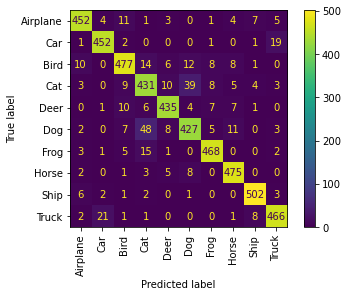

In [15]:
accuracy = validate(baseline, validationloader)

In [16]:
print(f"The baseline model has reached {accuracy * 100:.2f}% of weighted accuracy.")

The baseline model has reached 91.77% of weighted accuracy.


### 3. Adversarial attacking

This section presents implementatons of Fast Gradient Sign (FGSM), Projected Gradient Descent (PGD), and Carlini & Wagner (C&W) attacks. The impact of these attacks on a baseline model will be measured in terms of balanced accuracy score. The adversarial samples will be generated from validation set, on which the baseline scored 92% of balanced accuracy.

For FGSM and PGD there were also implemented targeted versions of attacks, which aims to maximize loss for ground truth and at the same time minimize loss for the target:
 $$max \text{ }  \mathcal{L}(F(x+\delta, \theta), y)) - \mathcal{L}(F(x+\delta, \theta), y_{targ})$$
 
Similar behaviour was adapted for the C&W method (see 3.3).

In [17]:
def visualize_single_attack(model, attack):
    """
    Method that visualizes result of an attack on a given model.
    The plot comprised of an original image and obtained adversarial 
    samples (both targeted and untargeted). Above each image there is 
    a caption with a baseline prediction.
    
    :param model: model to be attacked
    :param attack: tuple of name and instance of attack class
    :param random_sample: flag to test attack on random sample
    """
    model.cpu()
    name, f = attack
    idx = random.randint(0, len(validationset) - 1)
    image, label = validationset[idx]
    _image = image / 255.0
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)
    fig.suptitle(f'{name} applied to sample with label "{classes[label]}"')

    pred_original = model(_image.unsqueeze(0))
    _, pred_original_class = pred_original.max(1)
    ax1.set_title(f'Original: pred="{classes[pred_original_class[0].item()]}"')
    ax1.imshow(np.clip(_image.permute(1, 2, 0), 0, 1))
    
    adversarial = f(model, _image.unsqueeze(0), torch.LongTensor([label]))
    pred_adversarial = model(adversarial)
    _, pred_adversarial_class = pred_adversarial.max(1)
    ax2.set_title(f'Adversarial no target: pred="{classes[pred_adversarial_class[0].item()]}"')
    ax2.imshow(np.clip(adversarial[0].permute(1, 2, 0).detach().numpy(), 0, 1))
    
    target_idx = label
    while target_idx == label:
        target_idx = random.randint(0, len(labels_text) - 1)
    target_class = classes[target_idx]
    adversarial = f(model, _image.unsqueeze(0), torch.LongTensor([label]), torch.LongTensor([target_idx]))
    pred_adversarial = model(adversarial)
    _, pred_adversarial_class = pred_adversarial.max(1)
    ax3.set_title(f'Adversarial target {target_class}: pred="{classes[pred_adversarial_class[0].item()]}"')
    ax3.imshow(np.clip(adversarial[0].permute(1, 2, 0).detach().numpy(), 0, 1))
    
    plt.show()

In [18]:
def validate_adversarial(model, loader, attack):
    """
    Method that checks the performance on model on validation dataset 
    comprised of adversarial samples. For each mini-batch in validation 
    loader method generates adversarial mini-batch aimed to maximize the 
    loss. The impact of the attack is measured in terms of weighted accuracy.
    Additionally, the confusion matrix is plotted.

    :param model: model to be validated
    :param loader: input dataloader to generate adversarial samples
    :param attack: tuple of name and instance of attack class
    """
    name, f = attack
    model.to(configs['device'])
    model.eval()
    test_loss = 0.0
    history = {"True": [], "Predicted": []}
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(configs['device']), labels.to(configs['device'])
        adversarial = f(model, images / 255.0, labels)

        predictions = model(adversarial)
        _, predicted_classes = predictions.max(1)
        predicted_classes = predicted_classes.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        history["True"] += list(labels)
        history["Predicted"] += list(predicted_classes)
    
    accuracy = balanced_accuracy_score(history["True"], history["Predicted"])
    print(f"Attack {name}: The baseline model has reached {accuracy * 100:.2f}% of weighted accuracy.")
    
    ConfusionMatrixDisplay.from_predictions(history["True"], history["Predicted"], display_labels=labels_text, xticks_rotation='vertical')
    plt.show()

#### 3.1. Fast Gradient Sign Method (FGSM)

This approach was firstly presented by Goodfellow I. et al. in ["Explaining and Harnessing Adversarial Examples"](https://arxiv.org/pdf/1412.6572.pdf). The adversarial sample $\hat{x}$ in FGSM is defined as $\hat{x} = x + \delta = x + \epsilon \cdot sign(\nabla_x \mathcal{L}(F(x, \theta)), y)$, where coefficient $\epsilon$ is a magnitude of a maximal perturbation, function $F$ is a model with parameters $\theta$, function $\mathcal{L}$ is a loss function, and $\nabla_x$ corresponds to the gradient of $\mathcal{L}$ w.r.t. to sample $x$.

In [19]:
class FGSM:
    """
    Class implementing Fast Gradient Sign Method.
    This method adjusts an input sample x by a small step ϵ in direction
    of gradient ∇ and thus maximizing the loss.
    """
    
    def __init__(self, epsilon=0.05, criterion=nn.CrossEntropyLoss, device="cuda"):
        """
        Constructor of a class.
        
        :param epsilon: magnitude of a maximal perturbation
        :param criterion: loss function (default: Cross Entropy Loss)
        """
        self.epsilon = epsilon
        self.criterion = criterion
        self.device = device
    
    def __call__(self, model, x, y, target=None):
        """
        Method that overloads the call operands to perform an
        attack on model.
        
        :param model: model to be attacked
        :param x: predictors of an input sample
        :param y: labels of an input sample
        :param target: target of an attack
        :return: adversarial sample
        """
        return x + self._attack(model, x, y, target)

    def _attack(self, model, x, y, target):
        """
        Method that performs FGSM attack on a model. Adjusts an input sample x 
        by a small step ϵ in direction of gradient ∇ and thus maximizing the loss.
        
        :param model: model to be attacked
        :param x: predictors of an input sample
        :param y: labels of an input sample
        :param target: target of an attack
        :return: perturbation
        """
        perturbation = torch.zeros_like(x, requires_grad=True).to(self.device)
        predictions = model(x + perturbation)
        if target is not None:
            loss = self.criterion()(predictions, y) - self.criterion()(predictions, target) 
        else:
            loss = self.criterion()(predictions, y)
        loss.backward()
        delta = self.epsilon * perturbation.grad.detach().sign()
        return delta

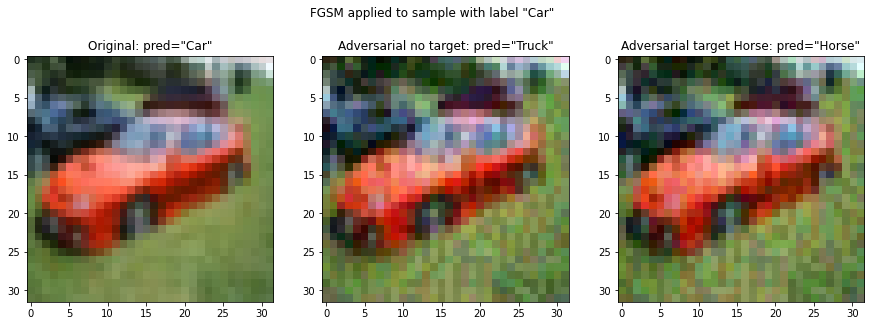

In [20]:
visualize_single_attack(baseline, ("FGSM", FGSM(device="cpu")))

Attack FGSM: The baseline model has reached 3.69% of weighted accuracy.


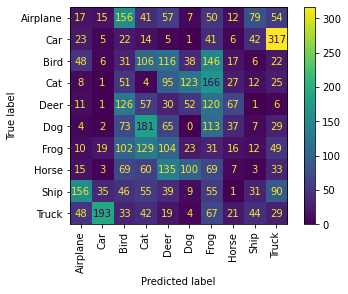

In [21]:
validate_adversarial(baseline, validationloader, ("FGSM", FGSM()))

#### 3.2. Projected Gradient Descent (PGD)

This approach was proposed by Madry A. et al. in ["Towards Deep Learning Models Resistant to Adversarial Attacks"](https://arxiv.org/pdf/1706.06083.pdf). The PGD is an iterative method, so the adversarial sample on each iteration is defined as $\hat{x} = x + \delta = clip_{(x, \epsilon)} \{ x + \alpha \cdot sign(\nabla_x \mathcal{L}(F(x, \theta), y)) \}$, where coefficient $\epsilon$ is a magnitude of a maximal perturbation, coefficient $\alpha$ can be treated as a learning rate, function $F$ is a model with parameters $\theta$, function $\mathcal{L}$ is a loss function, and $\nabla_x$ corresponds to the gradient of $\mathcal{L}$ w.r.t. to sample $x$.

In [22]:
class PGD:
    """
    Class implementing Projected Gradient Descent.
    """
    
    def __init__(self, alpha=5e-3, epsilon=0.05, iterations=10, criterion=nn.CrossEntropyLoss, device="cuda"):
        """
        Constructor of a class.
        
        :param epsilon: magnitude of a maximal perturbation
        :param criterion: loss function (default: Cross Entropy Loss)
        """
        self.alpha = alpha
        self.epsilon = epsilon
        self.iterations = iterations
        self.criterion = criterion
        self.device = device
    
    def __call__(self, model, x, y, target=None):
        """
        Method that overloads the call operands to perform an
        attack on model.
        
        :param model: model to be attacked
        :param x: predictors of an input sample
        :param y: labels of an input sample
        :param target: target of an attack
        :return: adversarial sample
        """
        return x + self._attack(model, x, y, target)

    def _attack(self, model, x, y, target, use_sgd=False):
        """
        Method that performs PGD attack on a model. Iteratively adjusts an input sample x 
        by a small step α in direction of gradient ∇ and thus maximizing the loss.
        
        :param model: model to be attacked
        :param x: predictors of an input sample
        :param y: labels of an input sample
        :param target: target of an attack
        :return: perturbation
        """
        perturbation = torch.zeros_like(x, requires_grad=True).to(self.device)
        optimizer = optim.SGD([perturbation], lr=self.alpha)
        for _ in range(self.iterations):
            optimizer.zero_grad()
            predictions = model(x + perturbation)
            if target is not None:
                loss = self.criterion()(predictions, y) - self.criterion()(predictions, target)
            else:
                loss = self.criterion()(predictions, y)
            loss.backward()
            
            if use_sgd:
                optimizer.step()
                perturbation.data.clamp_(-self.epsilon, self.epsilon)
                continue
            
            gradient_sign = perturbation.grad.detach().sign()
            delta = perturbation + self.alpha * gradient_sign
            perturbation.data = delta.clamp(-self.epsilon, self.epsilon)
            perturbation.grad.zero_()
        delta = perturbation.detach()
        return delta

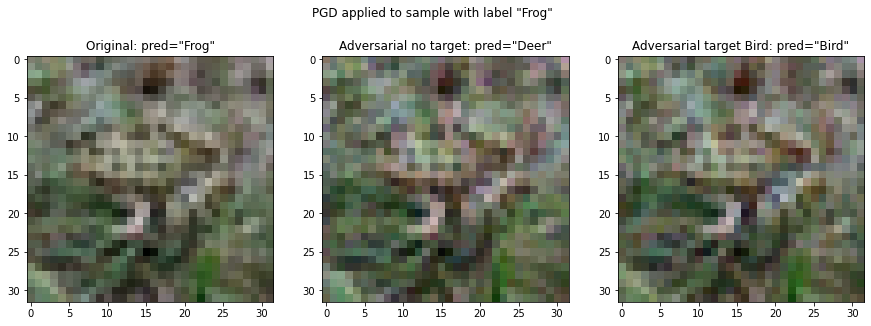

In [23]:
visualize_single_attack(baseline, ("PGD", PGD(device="cpu")))

Attack PGD: The baseline model has reached 0.00% of weighted accuracy.


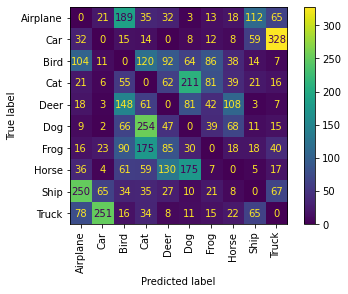

In [24]:
validate_adversarial(baseline, validationloader, ("PGD", PGD()))

#### 3.3. Carlini & Wagner (C&W)

This approach was proposed by Carlini and Wagner in ["Towards Evaluating the Robustness of Neural Networks"](https://arxiv.org/abs/1608.04644). The attack there is formulated as a minimization of $\mathcal{D}(x, x+\delta) + c \cdot f(x + \delta)$ such that $x + \delta \in [0, 1]^n$, where $\mathcal{D}$ is a distance metric (e.g. $l_2$ norm), and $f$ is an objective function. Authors suggest to use $f(x') = \max (\max_{i \neq t} (F(x')_i)-F(x')_t, 0)$ that correspond to $f_6$ in paper. The constant $c$ is a topic for further study, but from Fig.2 it seems that the value of $1.5$ is sufficient. To ensure that the output image is valid, the box constraint is defined through change the variables trick as $\delta_i=\frac{1}{2}(\tanh(w_i)+1)-x_i$.

In [25]:
class CnW:
    """
    Class implementing Carlini & Wagner attack.
    """
    
    def __init__(self, c=10, lr=1e-2, iterations=10, device="cuda"):
        """
        Constructor of a class.
        
        :param epsilon: magnitude of a maximal perturbation
        :param criterion: loss function (default: Cross Entropy Loss)
        """
        self.c = c
        self.lr = lr
        self.iterations = iterations
        self.device = device
    
    def __call__(self, model, x, y, target=None):
        """
        Method that overloads the call operands to perform an
        attack on model.
        
        :param model: model to be attacked
        :param x: predictors of an input sample
        :param y: labels of an input sample
        :param target: target of an attack
        :return: adversarial sample
        """
        return self._attack(model, x, y, target)

    def _attack(self, model, x, y, target):
        """
        Method that performs C&W attack on a model. Creates a new variable w
        that is used for optimization of adversarial sample. The objective 
        function comprised of L2-norm and rectifier function as suggested in 
        original paper.
        
        :param model: model to be attacked
        :param x: predictors of an input sample
        :param y: labels of an input sample
        :param target: target of an attack
        :return: adversarial sample
        """
        w = torch.atanh(2 * x - 1).to(self.device)
        w.requires_grad = True
        
        optimizer = optim.SGD([w], lr=self.lr)
        for _ in range(self.iterations):
            optimizer.zero_grad()
            adversarial_sample = 0.5 * (torch.tanh(w) + 1)
            l2_norm = nn.MSELoss()(adversarial_sample, x)     
            objective = self.c * self._f6(model, adversarial_sample, y, target).sum()
            loss = l2_norm + objective
            loss.backward()
            optimizer.step()
        return adversarial_sample.detach()
    
    def _f6(self, model, x, y, target):
        """
        Method implementing rectifier function f6 recommended for the
        use as a part of objective function in C&W attack.
        
        :param model: model to be attacked
        :param x: predictors of an input sample
        :param y: labels of an input sample
        :param target: target of an attack
        :return: adversarial sample
        """
        labels = y if target is None else target
        predictions = model(x)
        predictions_ = predictions.clone()
        predictions_[range(predictions_.shape[0]), labels] = torch.min(predictions) - 1
        max_non_target, _ = torch.max(predictions_, dim=1)
        prediction_target_idx = predictions[range(predictions_.shape[0]), labels]
        
        if target is not None:
            diff = max_non_target - prediction_target_idx
        else:
            diff = prediction_target_idx - max_non_target
        
        return torch.clamp(diff, min=0)

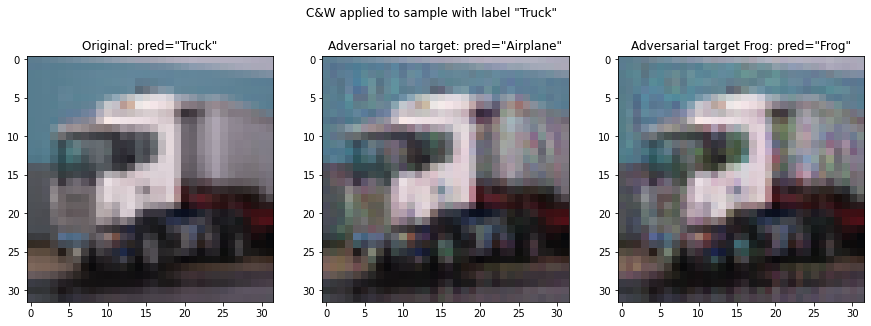

In [26]:
visualize_single_attack(baseline, ("C&W", CnW(device="cpu")))

Attack C&W: The baseline model has reached 0.00% of weighted accuracy.


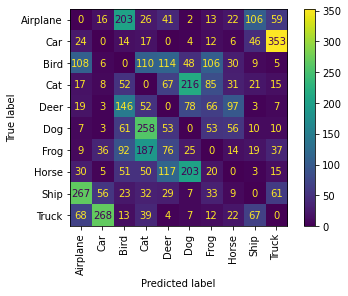

In [27]:
validate_adversarial(baseline, validationloader, ("C&W", CnW()))

#### 3.4. Discussion
In this section there were implemented three known adversarial attacks inter alia FGSM, PGD, and C&W. All of them managed to significantly reduce the balanced accuracy of a baseline (see Assignment 1): for FGSM balanced accuracy reached 3.69% whereas PGD and C&W performed better with correspondent value of 0.0%. This result was foreseeable considering the iterative nature of later attacks. Remarkably that this performance was reached with only 10 iterations. All the default values were chosen empirically and do not pretend to be the optimal: the hyperparameter tuning is out of scope of this assignment.

### 4. Adversarial Training

This section considers a problem of training a model that is robust to adversarial attacks. The simplest strategy is to incorporate adversarial samples in a training process. This also known as an adversarial training. My version of adversarial training will use all three attacks implemented in section 3, i.e. FGSM, PGD, and C&W. Adversarial samples are generated based on whole training set. Since the iterative methods are computationaly expensive, the number of iterations were reduced from 10 to 3. To make the comparison of a baseline with a robust model more fair, all the hyperparameters for training were taken from Assignment 1.

In [29]:
class AdversarialTraining:
    """
    Class implementing the adversarial training routine for ResNet.
    The configurations of model, criterion, optimizer and scheduler were taken as
    in the baseline with balanced accuracy of 92%.
    """
    
    def __init__(self, attack="__all__"):
        """
        :param model: model to be trained
        :param attack: type of attack, either "FGSM", "PGD", "SnW", or "__all__" 
        """
        self._make()
        self._attacks = {'FGSM': FGSM(), 'PGD': PGD(iterations=3), 'CnW': CnW(iterations=3)}
        self._initialize_attacks(attack)
    
    def fit(self):
        """
        Method that iteratively performs adversarial training. Could be 
        considered as an outline for a learning process.
        On each iteration saves model's weights locally.
        """
        for epoch in range(configs['epochs']):
            time_now = time()
            
            train_loss, train_accuracy = self._train_one_epoch()
            test_loss, test_accuracy = self._test_one_epoch()
            self.scheduler.step()
            
            self.losses['train'].append(train_loss)
            self.losses['test'].append(test_loss)
            self.accuracies['train'].append(train_accuracy)
            self.accuracies['test'].append(test_accuracy)
            
            print(f"Epoch: {epoch+1:02d} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train accuracy: {train_accuracy:.5f} | Test accuracy: {test_accuracy:.5f}")
            # print(f"Elapsed time: {time() - time_now}")
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': train_loss, 
            }, os.path.join("weights", f"{epoch}.pt"))
        
    def _make(self):
        """
        Method that initialize main components involved in training 
        process, namely model, objective function, optimizer, scheduler, 
        and lists to store metrics.
        """
        self.model = ResNet(3, 64, [3, 4, 6, 3])
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=0.0001, weight_decay=5e-4)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=configs['epochs'])
        self.losses = {"train": [], "test": []}
        self.accuracies = {"train": [], "test": []}
    
    def _initialize_attacks(self, attack):
        """
        Method that instantiate given by user attacks.
        
        :param attack: type of attack, either "FGSM", "PGD", "SnW", or "__all__" 
        """
        if attack == "__all__":
            self.attacks = {name: _attack for name, _attack in self._attacks.items()}
            return
        self.attacks = {attack: self._attacks[attack]()}
    
    def _train_one_epoch(self):
        """
        Method that performs one epoch of an adversarial training.
        The training process is performed on original data and adversarial samples
        generated based on it. Aggregates all the losses to adjust model's parameters.
        """
        self.model.to(configs['device'])
        self.model.train()

        train_loss = 0.0
        accuracy = []
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(configs['device']), labels.to(configs['device'])         
            self.optimizer.zero_grad()
            
            labels_all = []
            predicted_classes_all = []
            
            predictions1 = self.model(images / 255.0)
            loss1 = self.criterion(predictions1, labels)
            
            labels_all += list(labels.cpu().detach().numpy())
            _, predicted_classes = predictions1.max(1)
            predicted_classes_all += list(predicted_classes.cpu().detach().numpy())
            
            loss = loss1
            for name, attack in self.attacks.items():
                adversarial_example = attack(self.model, images / 255.0, labels)
                _predictions = self.model(adversarial_example)
                loss += self.criterion(_predictions, labels)
                
                labels_all += list(labels.cpu().detach().numpy())
                _, predicted_classes = _predictions.max(1)
                predicted_classes_all += list(predicted_classes.cpu().detach().numpy())
            
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()

            accuracy.append(balanced_accuracy_score(np.array(labels_all), np.array(predicted_classes_all)))

        return train_loss / len(trainloader), np.mean(np.array(accuracy))
    
    def _test_one_epoch(self):
        """
        Method that peforms testing routine for a model.
        """
        self.model.eval()
        test_loss = 0.0
        accuracy = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(testloader):
                images, labels = images.to(configs['device']), labels.to(configs['device'])
                predictions = self.model(images / 255.0)
                loss = self.criterion(predictions, labels)
                test_loss += loss.item()

                _, predicted_classes = predictions.max(1)
                predicted_classes = predicted_classes.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()
                accuracy.append(balanced_accuracy_score(labels, predicted_classes))

        return test_loss / len(testloader), np.mean(np.array(accuracy))
        

In [30]:
train = AdversarialTraining()

In [31]:
train.fit()

Epoch: 01 | Train loss: 11.59520 | Test loss: 2.45678 | Train accuracy: 0.01067 | Test accuracy: 0.02473
Epoch: 02 | Train loss: 10.24769 | Test loss: 2.36474 | Train accuracy: 0.00826 | Test accuracy: 0.01247
Epoch: 03 | Train loss: 9.93576 | Test loss: 2.41792 | Train accuracy: 0.00709 | Test accuracy: 0.02559
Epoch: 04 | Train loss: 9.91267 | Test loss: 2.42469 | Train accuracy: 0.00797 | Test accuracy: 0.01539
Epoch: 05 | Train loss: 9.73575 | Test loss: 2.31725 | Train accuracy: 0.00709 | Test accuracy: 0.08759
Epoch: 06 | Train loss: 9.76264 | Test loss: 2.31963 | Train accuracy: 0.00711 | Test accuracy: 0.01647
Epoch: 07 | Train loss: 9.70266 | Test loss: 2.32143 | Train accuracy: 0.00718 | Test accuracy: 0.01521
Epoch: 08 | Train loss: 9.57319 | Test loss: 2.30381 | Train accuracy: 0.00814 | Test accuracy: 0.01428
Epoch: 09 | Train loss: 9.59167 | Test loss: 2.32496 | Train accuracy: 0.00814 | Test accuracy: 0.00762
Epoch: 10 | Train loss: 9.45248 | Test loss: 2.45153 | Train a

From a first glance, the performance of a model on a test set is poor: it has reached 47.83% of weighted accuracy after 50 epochs compared to 91.46% for a baseline. For a further inference there will be used model parameters at epoch 48. Since they weight too much (~256 Mb), I have uploaded them to the [cloud](https://drive.google.com/file/d/1gv6rZ46GpSJ8SHEeW7oR0uORnqwT4Fea/view?usp=sharing).

### 5. Robust Inference

This section provides a discussion of robustness of a novel model after applying the defense. Similarly to section 2, 3 the performance of a model will be measured in terms of balanced accuracy on validation dataset and adversarial samples generated using FGSM, PGD and C&W.

In [32]:
checkpoint = torch.load(os.path.join("weights", "robust.pt"))
robust = ResNet(3, 64, [3, 4, 6, 3]).to(configs['device'])
robust.load_state_dict(checkpoint['model_state_dict'])
robust.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2

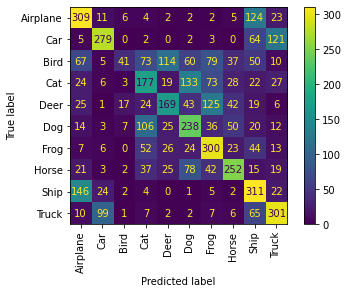

The baseline model has reached 47.86% of weighted accuracy.


In [33]:
accuracy = validate(robust, validationloader)
print(f"The baseline model has reached {accuracy * 100:.2f}% of weighted accuracy.")

Attack FGSM: The baseline model has reached 14.02% of weighted accuracy.


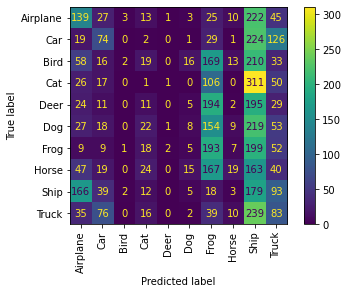

In [34]:
validate_adversarial(robust, validationloader, ("FGSM", FGSM()))

Attack PGD: The baseline model has reached 4.88% of weighted accuracy.


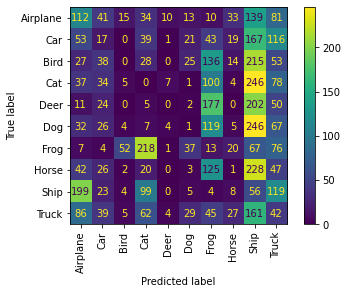

In [35]:
validate_adversarial(robust, validationloader, ("PGD", PGD()))

Attack C&W: The baseline model has reached 33.30% of weighted accuracy.


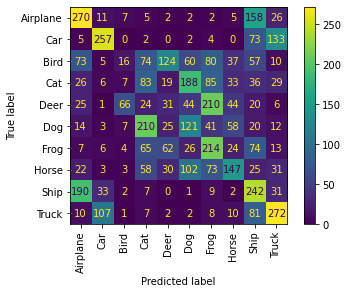

In [36]:
validate_adversarial(robust, validationloader, ("C&W", CnW()))

The comparison of baseline and robust models is shown in the table below.

|                | Baseline | Robust |
|----------------|----------|--------|
| Validation set |   91.77  |  47.86 |
| FGSM           |   3.69   |  14.02 |
| PGD            |   0.00   |  4.88  |
| C&W            |   0.00   |  33.30 |

There we can clearly see the trade-off between the accuracy and robustness: baseline that is perferct in terms of accuracy performs poorly on adversarial samples whereas not so accurate "robust" model performs better on adversarial samples.

Honestly, the obtained results make me feel that the whole concept of neural networks is (perhaps) wrong. Among the news about the (about-) human level of object classification by SoA methods, for some reason we do not notice that neural networks do not really understand what they are doing and why.